In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl

import sys
from tqdm import tqdm
sys.path.append('../../../wdtools/')
sys.path.append('../../../../isochrones/')
from astropy.io import fits
import scipy
#plt.style.use('vedant')
from bisect import bisect_left
import lmfit
import isochrones
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458 # m/s
radius_sun = 696340000 # m 
g_sun = 273.95 # m/s
pc_to_m = 3.086e+16
mass_sun = 1.9884e30
newton_G = 6.674e-11

na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52
ca2k = 3934.777
ca2h = 3969.58

import pyphot
from pyphot import unit
plt.rcParams.update({'font.size': 18})

Holoviews not imported. Some visualizations will not be available.


In [2]:
lib = pyphot.get_library()
mean_wls = np.asarray([3596, 4639, 6122,7439,8896])
lamgrid = np.linspace(3500, 9000, 9000 - 3500)
abs_distance = 10 # pc

## MPMS

In [3]:
def logg_to_radius(logg):
    g = 10**logg * 0.01 # to SI
    
    R = radius_sun * 10 ** ( - ((np.log10(g / g_sun) + 0.02) / 0.67))
    return R

interpsda = pickle.load(open('interp/interpsda.p', 'rb'))

def get_sda(teff, logg, wl):
    return 10**interpsda((logg, teff, np.log10(wl)))

def get_cal_spec_mpms(teff, logg):
    
    mfl = get_sda(teff, logg, lamgrid)

    mfl = mfl / np.pi 

    radius = logg_to_radius(logg) ## CHANGE THIS TO INTERPOLATE ISOCHRONE
    distance = abs_distance * pc_to_m

    solid_angle = (radius / distance) ** 2

    mfl = solid_angle * mfl * 1e-8 #### ADD GP or EXTINCTION?
    
    return mfl

def get_sdss_sed_mpms(teff, logg, to_mag = True):
    
    if to_mag:
        fl = get_sda(teff, logg, lamgrid) * 1e-8
        #fl = get_cal_spec_mpms(teff, logg)
        wl = lamgrid * unit['AA']
        fl = fl * unit['erg/cm**2/s/AA']
        sed = [];
        for band in ['u', 'g', 'r', 'i', 'z']:
            f = lib['SDSS_' + band]
            se = f.get_flux(wl, fl)
            se = -2.5 * np.log10(se) - f.AB_zero_mag
            sed.append(se)

        #sed = np.asarray(sed) * mean_wls**2 * 1000 / 2.99e21 
        #sed = -2.5 * np.log10(sed) - 48.60
        return sed
    
    fl = get_cal_spec_mpms(teff, logg)
    wl = lamgrid * unit['AA']
    fl = fl * unit['erg/s/cm**2/AA']
    sed = [];
    for band in ['u', 'g', 'r', 'i', 'z']:
        f = lib['SDSS_' + band]
        se = f.get_flux(wl, fl)
        sed.append(se)
        
    sed = np.asarray(sed)
    
    return sed

## WD

In [4]:
sys.path.append('../../../')
import WD_models
fontaine_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**fontaine_model['logg'])/100

rsun = np.sqrt(fontaine_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun

logg_teff_to_rsun = WD_models.interp_xy_z_func(x = fontaine_model['logg'], y = 10**fontaine_model['logteff'],\
                                                z = rsun, interp_type = 'linear')

In [5]:
interpwd = pickle.load(open('interp/interpwd.p', 'rb'))
def get_wd(teff, logg, wl):
    return 10**interpwd((logg, teff, np.log10(wl)))

In [6]:
abs_distance = 10
def get_cal_spec_wd(teff, logg):
    
    mfl = get_wd(teff, logg, lamgrid)

    radius = logg_teff_to_rsun(logg, teff) * radius_sun
    distance = abs_distance * pc_to_m

    solid_angle = 4 * np.pi * (radius / distance) ** 2

    mfl = solid_angle * mfl            #### ADD GP or EXTINCTION?
    mfl = 2.99e21 * (mfl/1000) * (1 /lamgrid**2)
    
    return mfl

In [7]:
def get_sdss_sed_wd(teff, logg, to_mag = True):
    fl = get_cal_spec_wd(teff, logg)
    if to_mag:
        fl = get_wd(teff, logg, lamgrid)
    wl = lamgrid * unit['AA']
    fl = fl * unit['erg/s/cm**2/Hz']
    sed = [];
    for band in ['u', 'g', 'r', 'i', 'z']:
        f = lib['SDSS_' + band]
        se = f.get_flux(wl, fl)
        sed.append(se)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed) - 48.60
    return sed

## Generate SEDS and Colors

In [8]:
import itertools

In [22]:
n_teff = 25
n_logg = 5
n_models = n_teff * n_logg

teffs = np.linspace(3000, 5000, n_teff)
wd_loggs = np.linspace(7.05, 9, n_logg)
mpms_loggs = np.linspace(3.5, 5.5, n_logg)

In [23]:
wd_param_grid = np.array(list(itertools.product(teffs, wd_loggs)))
mpms_param_grid = np.array(list(itertools.product(teffs, mpms_loggs)))

In [24]:
wd_seds = np.asarray([get_sdss_sed_wd(teff, logg, True) for teff,logg in wd_param_grid])
mpms_seds = np.asarray([get_sdss_sed_mpms(teff, logg, True) for teff, logg in mpms_param_grid])

In [25]:
wd_colors = np.diff(wd_seds, axis = 1)
mpms_colors = np.diff(mpms_seds, axis = 1)

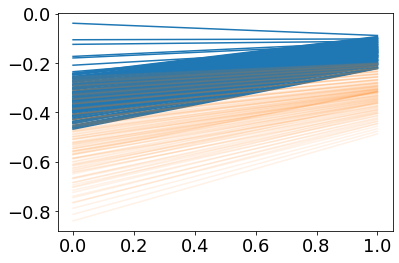

In [26]:
plt.plot(wd_colors.T[2:,:], color = 'C0');
plt.plot(mpms_colors.T[2:,:], color = 'C1', alpha = 0.1);

In [13]:
len(wd_colors)

500

In [ ]:
balmer_features = np.loadtxt('tables/balmer_features.txt')

## LR

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [ ]:
X = np.vstack((wd_colors, mpms_colors))

t = np.zeros(len(X))
t[len(wd_colors):] = 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size = 0.05)

In [ ]:
lr = LogisticRegression(penalty = 'l2', solver = 'saga', max_iter = 10000, tol = 1e-8)

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
pickle.dump(lr, open('LR/phot_lr.p', 'wb'))

## griz only

In [ ]:
X = np.vstack((wd_colors, mpms_colors))
X = X[:, 1:]
t = np.zeros(len(X))
t[len(wd_colors):] = 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size = 0.05)

In [ ]:
lr = LogisticRegression(penalty = 'l2', max_iter = 10000, tol = 1e-8)

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
pickle.dump(lr, open('LR/phot_lr_griz.p', 'wb'))

## Combined with Balmer

In [ ]:
X = np.vstack((wd_colors, mpms_colors))
X = np.hstack((X, balmer_features))
t = np.zeros(len(X))
t[len(wd_colors):] = 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size = 0.05)

In [ ]:
lr = LogisticRegression(penalty = 'l2', max_iter = 10000, tol = 1e-8)

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
pickle.dump(lr, open('LR/combined.p', 'wb'))

## Write Training Grid

In [ ]:
features = ['ug', 'gr', 'ri', 'iz', 'a_fwhm', 'a_height',
                                               'b_fwhm', 'b_height',
                                               'g_fwhm', 'g_height',
                                               'd_fwhm', 'd_height']

In [ ]:
df = pd.DataFrame(X, columns = features)

In [ ]:
df['is_mpms'] = t.astype(int)

In [ ]:
df.to_csv('../training_grid.csv')